In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from sklearn.preprocessing import normalize

### Загрузка файлов

In [2]:
employees_df = pd.read_csv("employees.csv", sep = ';')
courses_passing_df = pd.read_csv("courses_passing.csv", sep = ';')
course_employee_sms_df = pd.read_csv("course_employee_sms.csv", sep = ';')
communications_df = pd.read_csv("communications.csv", sep = ';')


## Изменение качества коммуникации (по месяцам)

In [3]:
num_employees = len(employees_df.index)
num_employees

2381

In [4]:
communications_df['communication_dt'] = pd.to_datetime(communications_df['communication_dt'] )
communications_df['communication_period'] = communications_df["communication_dt"].dt.to_period("M")
communications_eff = communications_df.groupby(['employee_id','communication_period'])["communication_score"].mean()
num_of_periods = int(communications_eff.count()/num_employees)
communications_eff_arr = communications_eff.to_numpy().reshape(num_employees,num_of_periods)
communications_eff_timeseries = pd.DataFrame(communications_eff_arr,columns=range(0,num_of_periods))
communications_eff_timeseries["user_id"] = communications_eff.index.get_level_values(0)[0:communications_eff.count():num_of_periods]
communications_eff_timeseries.set_index('user_id',inplace = True)

In [5]:
communications_eff_timeseries.head()

,0,1,2,3,4,5,6,7,8,9,10,11
user_id,,,,,,,,,,,,
0004d0b5-9e19-461f-f126-e3a08a814c33,60.434783,56.605505,56.407895,57.142322,60.670455,57.660156,56.765766,55.636029,56.475524,55.944134,52.895522,60.588235
00411460-f7c9-2d21-24a6-7ea0f4cb5f85,50.537313,49.901099,59.029197,55.551913,53.781095,55.476852,60.317568,60.018868,62.126087,58.030303,58.386792,50.203704
006f52e9-102a-8d3b-e2fe-5614f42ba989,59.925373,55.695652,58.630303,58.946429,55.750000,58.411290,64.481707,64.857143,66.167969,61.592760,63.824818,62.887640
0070d23b-06b1-486a-538c-0eaa45dd167a,60.752577,59.914062,56.558140,57.476562,56.566176,58.174074,60.829268,62.119048,57.041667,56.139175,58.986667,64.172043
008bd5ad-93b7-54d5-0033-8c253d9c1770,56.703297,60.259740,58.645161,56.173077,59.293839,56.482014,59.566038,53.783410,56.862745,56.201005,54.060403,50.333333


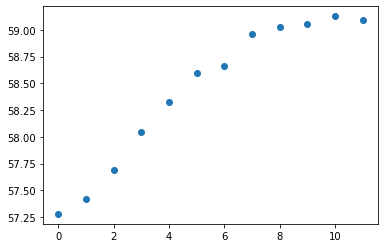

In [6]:
communications_eff_timeseries_arr = communications_eff_timeseries.mean(axis=0).to_numpy()
months = np.arange(12)
plt.plot(months, communications_eff_timeseries_arr, 'o')
plt.show()

Видно, что в среднем эффективность коммуникации у работников растет и выходит на "плато". Это может быть связано как с прохождением обучающих курсов, так и с увеличением опыта работы.

# Определение лучшего курса для каждого работника

Рассматриваются только полностью пройденные курсы. Эффект от прохождения курса оценивается по нормированной разности "communication_score" за месяц после окончания и месяц до начала прохождения. Нормировка нужна для учёта роста среднего "communication_score" в течении года (картинка выше).

In [7]:
courses_passed_df = courses_passing_df[courses_passing_df.pass_frac == 1]
courses_passed_df.describe()

,course_id,pass_frac,educ_duration_days
count,8513.000000,8513.0,8404.000000
mean,44.169975,1.0,10.037482
std,26.970102,0.0,3.122765
min,0.000000,1.0,1.000000
25%,20.000000,1.0,8.000000
50%,43.000000,1.0,10.000000
75%,67.000000,1.0,12.000000
max,91.000000,1.0,23.000000


In [8]:
#соединяем таблички, образуя всевозможные комбинации курс-работник
merged_df = communications_df.merge(courses_passed_df,how='inner', on='employee_id')
merged_df = merged_df.dropna()
merged_df['end_dt'] = pd.to_datetime(merged_df['end_dt'] )
merged_df['start_dt'] = pd.to_datetime(merged_df['start_dt'] )
merged_df

,communication_id,communication_dt,employee_id,communication_score,util_flg,communication_period,course_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
0,177074281189583840,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,85,0,2023-02,79,1.0,2023-06-25,2023-07-05 00:00:00,2023-07-05,10.0
1,177074281189583840,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,85,0,2023-02,74,1.0,2023-07-06,2023-07-15 00:00:00,2023-07-15,9.0
2,177074281189583840,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,85,0,2023-02,16,1.0,2023-06-03,2023-06-09 00:00:00,2023-06-09,6.0
3,177074281189583840,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,85,0,2023-02,8,1.0,2023-07-13,2023-07-20 00:00:00,2023-07-20,7.0
4,177074281189583840,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,85,0,2023-02,42,1.0,2023-04-09,2023-04-15 00:00:00,2023-04-15,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19368687,338432683508589789,2023-11-29,193002e6-6875-8ea9-7629-04da1a22337c,43,0,2023-11,68,1.0,2023-06-26,2023-07-09 00:00:00,2023-07-09,13.0
19368688,338432683508589789,2023-11-29,193002e6-6875-8ea9-7629-04da1a22337c,43,0,2023-11,90,1.0,2023-07-13,2023-07-22 00:00:00,2023-07-22,9.0
19368689,338432683508589789,2023-11-29,193002e6-6875-8ea9-7629-04da1a22337c,43,0,2023-11,20,1.0,2023-09-08,2023-09-16 00:00:00,2023-09-16,8.0
19368690,338432683508589789,2023-11-29,193002e6-6875-8ea9-7629-04da1a22337c,43,0,2023-11,56,1.0,2023-01-11,2023-01-20 00:00:00,2023-01-20,9.0


In [9]:
merged_df.describe()

,communication_id,communication_score,util_flg,course_id,pass_frac,educ_duration_days
count,1.912966e+07,1.912966e+07,1.912966e+07,1.912966e+07,19129660.0,1.912966e+07
mean,5.005431e+17,5.996475e+01,7.581515e-01,4.417805e+01,1.0,1.003866e+01
std,2.918245e+17,3.717633e+01,4.282030e-01,2.695136e+01,0.0,3.117668e+00
min,1.052382e+09,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.000000e+00
25%,2.441491e+17,3.200000e+01,1.000000e+00,2.000000e+01,1.0,8.000000e+00
50%,5.009875e+17,6.900000e+01,1.000000e+00,4.300000e+01,1.0,1.000000e+01
75%,7.569293e+17,1.000000e+02,1.000000e+00,6.700000e+01,1.0,1.200000e+01
max,9.999998e+17,1.000000e+02,1.000000e+00,9.100000e+01,1.0,2.300000e+01


In [10]:
#добавляем новый столбец (в него записываем - до или после прохождения курса произошла коммуникация)
merged_df['period'] =  merged_df.apply(lambda row: "after" if ((row['communication_dt'] > row['end_dt']) and (row['communication_dt'] < (row['end_dt'] + np.timedelta64(30, 'D'))))
                                       else "before" if ((row['communication_dt'] < row['start_dt']) and (row['communication_dt']>(row['start_dt'] - np.timedelta64(30, 'D'))))
                                       else "not in range",axis = 1)


In [30]:
#создаем датафрейм со средними значениями скора до и после прохождения курcа
pivot_df = pd.pivot_table(merged_df , values = 'communication_score',
index=['employee_id','course_id'], columns = ['period'], aggfunc=np.mean)
pivot_df

period                                              after     before  \
employee_id                          course_id                         
00411460-f7c9-2d21-24a6-7ea0f4cb5f85 7          51.180723  44.162162   
                                     8          58.879121  59.816176   
                                     20         61.271429  54.013453   
                                     29         59.250000  55.598958   
                                     50         62.396396  58.080808   
...                                                   ...        ...   
ffeed84c-7cb1-ae7b-f4ec-4bd78275bb98 46         57.559633  60.516854   
                                     51         61.005076  58.653333   
                                     74         62.417266  60.901587   
                                     79         61.687943  60.701087   
                                     82         58.730159  59.234568   

period                                          not in range  
employee_id                          course_id                
00411460-f7c9-2d21-24a6-7ea0f4cb5f85 7             57.708428  
                                     8             56.718228  
                                     20            57.233972  
                                     29            57.155440  
                                     50            56.226648  
...                                                      ...  
ffeed84c-7cb1-ae7b-f4ec-4bd78275bb98 46            62.163170  
                                     51            62.138889  
                                     74            61.883796  
                                     79            61.889750  
                                     82            62.361985  

[8404 rows x 3 columns]

In [31]:
#для каждого работника оределяем лучший курс и добавляем табличку с фичами работников
pivot_df = pivot_df.reset_index()
pivot_df["diff"] = (pivot_df["after"] - pivot_df["before"])/((pivot_df["after"] + pivot_df["before"]))
idx = pivot_df.groupby('employee_id')["diff"].transform(np.max) == pivot_df["diff"]
pivot_df = pivot_df[idx]
pivot_df = pivot_df.merge(employees_df, how='left', on='employee_id')
pivot_df

,employee_id,course_id,after,before,not in range,diff,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg
0,00411460-f7c9-2d21-24a6-7ea0f4cb5f85,7,51.180723,44.162162,57.708428,0.073614,F,3,29,3c59dc04-8e88-5024-3be8-079a5c74d079,378,1,1,1
1,006f52e9-102a-8d3b-e2fe-5614f42ba989,81,65.023669,59.903553,61.124618,0.040985,F,0,24,182be0c5-cdcd-5072-bb18-64cdee4d3d6e,452,2,2,1
2,00a03ec6-533c-a7f5-c644-d198d815329c,54,57.292453,46.888889,63.126050,0.099860,M,4,34,c9e1074f-5b3f-9fc8-ea15-d152add07294,188,2,2,1
3,00ac8ed3-b432-7bdd-4ebb-ebcb2ba10a00,56,55.771084,54.399123,59.245207,0.012453,M,0,29,812b4ba2-87f5-ee0b-c9d4-3bbf5bbe87fb,86,2,2,1
4,00e26af6-ac3b-1c1c-49d7-c3d79c60d000,66,58.338095,56.453744,57.281920,0.016415,M,0,38,e2ef524f-bf3d-9fe6-11d5-a8e90fefdc9c,247,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,ff1418e8-cc99-3fe8-abcf-e3ce2003e5c5,43,61.492147,58.964912,58.302053,0.020980,M,5,44,7647966b-7343-c290-4867-3252e490f736,314,1,2,1
1679,ff49cc40-a889-0e6a-60f4-0ff3026d2730,29,56.188235,62.377907,57.658220,-0.052204,M,7,30,d82c8d16-19ad-8176-d665-453cfb2e55f0,324,2,2,1
1680,fface838-5abb-f94b-4593-a0ed53a0c70f,63,58.800604,53.050000,58.728480,0.051413,F,7,25,72b32a1f-754b-a1c0-9b36-95e0cb6cde7f,395,2,1,1
1681,ffedf5be-3a86-e2ee-281d-54cdc97bc1cf,43,56.080952,50.089109,58.592992,0.056436,M,3,27,a3c65c29-7427-0fd0-93ee-8a9bf8ae7d0b,558,0,1,1


# Модель
Модель должна предсказывать наилучший курс для работника. В качестве параметров, по которым определяется курс были выбраны наиболее коррелирующие с эффективностью коммуникации переменные. Как следует из проведенного эксплораторного анализа - это 'age', 'exp_days'.

Основной идеей подхода является кластеризация по выбранным признакам. Пространство параметров делится на равные части, формирующие кластеры (От наименее опытных и молодых работников до более пожилых и опытных)

Рекомендательная система предлагает работнику курс принадлежащий топ-5 курсов по приросту эффективности коммуникации для соответствующего работнику кластера.



In [32]:
from sklearn.model_selection import train_test_split

In [33]:
n_clust_age = 3
n_clust_exp = n_clust_age
empl_clust_simple = n_clust_age*pd.qcut(pivot_df["age"], q=n_clust_age, labels=False)+pd.qcut(pivot_df["exp_days"], q=n_clust_exp, labels=False)

In [34]:
pivot_temp = []
temp = []
for i in range(n_clust_age*n_clust_exp):
        pivot_df_i = pivot_df[empl_clust_simple==i]
        pivot_df_i["diff"]=(np.array(pivot_df_i["diff"])-np.min(pivot_df_i["diff"]))/(np.max(pivot_df_i["diff"])-np.min(pivot_df_i["diff"]))
        pivot_df_i = pivot_df_i.groupby("course_id").agg({"employee_id" : "count", "diff" : "mean"})
        pivot_df_i["value"] = pivot_df_i["employee_id"]*pivot_df_i["diff"]
        pivot_temp.append(pivot_df_i.sort_values("value", ascending = False))
        temp.append(list(pivot_df_i.sort_values("value", ascending = False).index))     

/var/folders/gy/92sb6trn21j21_xjd024bdvc0000gn/T/ipykernel_1996/2556335564.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df_i["diff"]=(np.array(pivot_df_i["diff"])-np.min(pivot_df_i["diff"]))/(np.max(pivot_df_i["diff"])-np.min(pivot_df_i["diff"]))


In [35]:
top_len = 5
best_courses = np.array([i[:top_len] for i in temp])

В переменной best_courses содержится топ-5 курсов для каждого кластера.

# Оценка точности модели

Частота разбиения является единственным гиперпараметром данной модели. Он был подобран вручную путём максимизации точности предсказания и равен 3.

In [36]:
data_train, data_test = train_test_split(pivot_df, test_size=200, random_state=42)

In [37]:
n_clust_age = 3
n_clust_exp = n_clust_age
empl_clust_simple = n_clust_exp*pd.qcut(data_train["age"], q=n_clust_age, labels=False)+pd.qcut(data_train["exp_days"], q=n_clust_exp, labels=False)
bins_clust_age = pd.qcut(data_train["age"], q=n_clust_age, labels=False, retbins=True)[1]
bins_clust_age[0] = 0
bins_clust_age[-1] = +np.inf
bins_clust_exp = pd.qcut(data_train["exp_days"], q=n_clust_exp, labels=False, retbins=True)[1]
bins_clust_exp[0] = 0
bins_clust_exp[-1] = +np.inf

In [38]:
pivot_temp = []
temp = []
for i in range(n_clust_age*n_clust_exp):
        pivot_df_i = data_train[empl_clust_simple==i]
        pivot_df_i["diff"]=(np.array(pivot_df_i["diff"])-np.min(pivot_df_i["diff"]))/(np.max(pivot_df_i["diff"])-np.min(pivot_df_i["diff"]))
        pivot_df_i = pivot_df_i.groupby("course_id").agg({"employee_id" : "count", "diff" : "mean"})
        pivot_df_i["value"] = pivot_df_i["employee_id"]*pivot_df_i["diff"]
        pivot_temp.append(pivot_df_i.sort_values("value", ascending = False))
        temp.append(list(pivot_df_i.sort_values("value", ascending = False).index))     

/var/folders/gy/92sb6trn21j21_xjd024bdvc0000gn/T/ipykernel_1996/3632034354.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_df_i["diff"]=(np.array(pivot_df_i["diff"])-np.min(pivot_df_i["diff"]))/(np.max(pivot_df_i["diff"])-np.min(pivot_df_i["diff"]))


In [39]:
top_len = 5
best_courses = np.array([i[:top_len] for i in temp])

In [44]:
temp1 = np.array(n_clust_exp*pd.cut(data_test["age"], bins_clust_age, labels=False)+pd.cut(data_test["exp_days"], bins_clust_exp, labels=False), dtype=int)
res = np.array([data_test["course_id"].iloc[i] in best_courses[temp1[i]] for i in range(len(temp1))])
np.sum(res)/len(res)

0.22